In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0117.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0101.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0108.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0110.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0119.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0115.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0116.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0105.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0106.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0121.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0111.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0103.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0120.jpeg
/kaggle/input/covid19-image-dataset/Co

# **IMPORTING LIBRARIES**

In [8]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [9]:
# re-size all the images to specific model
IMAGE_SIZE = [224, 224] 

# training config:
batch_size = 16 #Change for cpu-32

In [10]:
#paths
TRAINING_DIR = '../input/covid19-image-dataset/Covid19-dataset/train'
TESTING_DIR = '../input/covid19-image-dataset/Covid19-dataset/test'

# **DATA AUGMENTATION AND VISUALISATION**

In [14]:
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

In [21]:
# create an instance of ImageDataGenerator - general
gen = ImageDataGenerator(
    A.Compose(
    [A.CLAHE(),
     A.RandomRotate90(),
     A.Transpose(),
     A.Blur(blur_limit=3)]),
     rotation_range=40,
     width_shift_range=0.2,
     height_shift_range=0.2,
     rescale=None,
     shear_range = 0.2,
     zoom_range = 1.2, 
     horizontal_flip=True,
     fill_mode='nearest'
)

In [22]:
# create generators
train_generator = gen.flow_from_directory(
  TRAINING_DIR,
  target_size=IMAGE_SIZE,
  shuffle=True,
  seed=42,
  class_mode='binary',
  classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
  batch_size=batch_size,
)
test_generator = gen.flow_from_directory(
  TESTING_DIR,
  target_size=IMAGE_SIZE,
  shuffle=True,
  seed=42,
  class_mode='binary',
  classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
  batch_size=batch_size,
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [23]:
total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})



 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


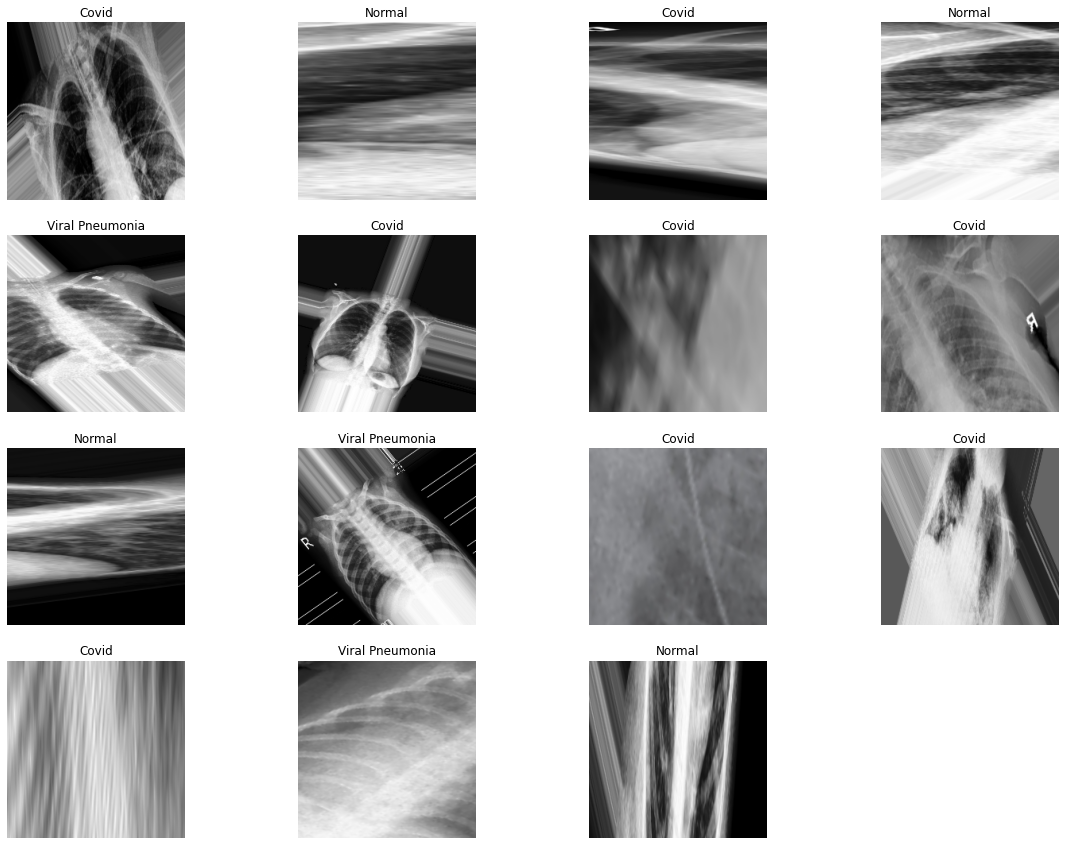

In [25]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers].astype('uint8')
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


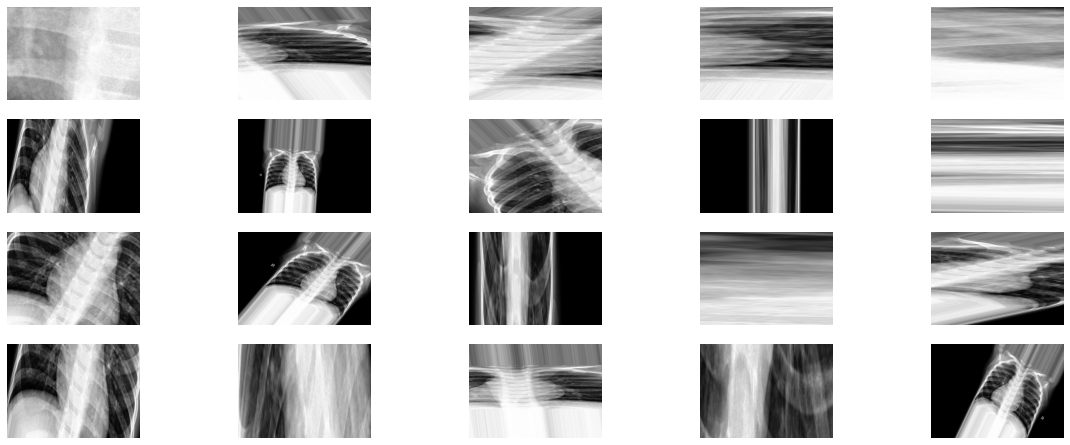

In [19]:
# example of data aug polyp
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0110.jpeg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = gen
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
pyplot.figure(figsize=(20,10))
for i in range(20):
    # define subplot
    pyplot.subplot(5,5,i+1)
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    pyplot.grid(False)
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(image)
  
# show the figure
pyplot.show()

# **MODEL TRAINING ANBD TESTING**

In [27]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (224, 224, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

2022-12-11 06:24:58.176922: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58900480/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________

In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

2022-12-11 06:25:40.461615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
16/16 [==============================] - 76s 5s/step - loss: 4.6422 - acc: 0.3466 - val_loss: 1.3697 - val_acc: 0.5303

Epoch 00001: acc improved from -inf to 0.34661, saving model to model/vgg16_best.h5
Epoch 2/50
16/16 [==============================] - 74s 5s/step - loss: 2.6845 - acc: 0.3865 - val_loss: 1.3627 - val_acc: 0.5303

Epoch 00002: acc improved from 0.34661 to 0.38645, saving model to model/vgg16_best.h5
Epoch 3/50
16/16 [==============================] - 74s 5s/step - loss: 2.0682 - acc: 0.4781 - val_loss: 1.0376 - val_acc: 0.5152

Epoch 00003: acc improved from 0.38645 to 0.47809, saving model to model/vgg16_best.h5
Epoch 4/50
16/16 [==============================] - 74s 5s/step - loss: 1.9825 - acc: 0.4781 - val_loss: 0.8957 - val_acc: 0.5303

Epoch 00004: acc did not improve from 0.47809
Epoch 5/50
16/16 [==============================] - 74s 5s/step - loss: 1.5402 - acc: 0.4741 - val_loss: 1.0888 - val_acc: 0.3788

Epoch 00005: acc did not improve from 0.4

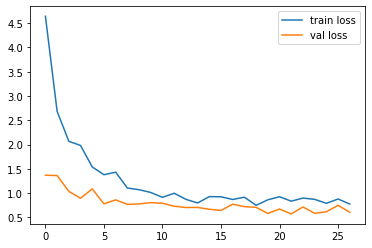

In [31]:
#plot some data
# loss
# plt.figure(dpi=600)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

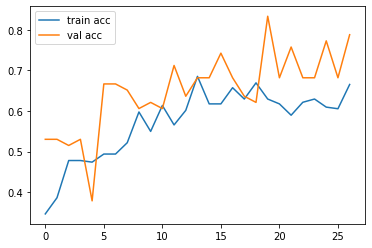

In [32]:
# accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [33]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

5/5 [==============================] - 15s 3s/step - loss: 0.6679 - acc: 0.6818


,Train,Val
Loss,0.634285,0.667889
Acc,0.733068,0.681818


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


              precision    recall  f1-score   support

         0.0       0.66      0.47      0.55        70
         1.0       0.71      0.63      0.67        70
         2.0       0.72      0.90      0.80       111

    accuracy                           0.71       251
   macro avg       0.70      0.67      0.67       251
weighted avg       0.70      0.71      0.69       251



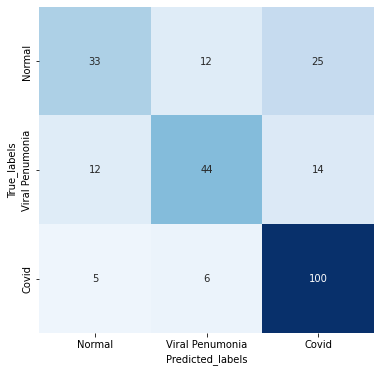

In [34]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


              precision    recall  f1-score   support

         0.0       0.77      0.50      0.61        20
         1.0       0.59      0.65      0.62        20
         2.0       0.74      0.88      0.81        26

    accuracy                           0.70        66
   macro avg       0.70      0.68      0.68        66
weighted avg       0.70      0.70      0.69        66



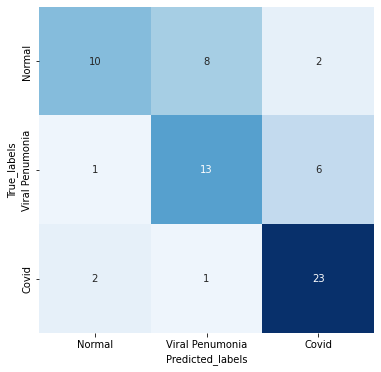

In [35]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))